In [20]:
import random
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Twitter API Configuration

In [21]:
import requests
import os
import json

In [22]:
# bearer_token = os.environ['BEARER_TOKEN']

def create_url(tweetIDS):
    ids = "ids=" + tweetIDS
    tweet_fields = "tweet.fields=source,lang,created_at,public_metrics,context_annotations"
    url = "https://api.twitter.com/2/tweets?{}&{}".format(ids, tweet_fields)
    return url


def bearer_oauth(r):
    r.headers["Authorization"] = f"Bearer {bearer_token}"
    r.headers["User-Agent"] = "v2TweetLookupPython"
    return r


def connect_to_endpoint(url):
    response = requests.request("GET", url, auth=bearer_oauth)
    print(response.status_code)
    if response.status_code != 200:
        raise Exception(
            "Request returned an error: {} {}".format(
                response.status_code, response.text
            )
        )
    return response.json()

# Importing Research Data

In [23]:
# data sourced from: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0182487

df = pd.read_excel('pone.0182487.s003.xlsx')

In [24]:
df.head()

,S1 Table - Tweet data and labels,Unnamed: 1
0,We have used the data according to the Twitter...,NaN
1,NaN,NaN
2,NaN,NaN
3,Tweet id,Label
4,732113301144883204,0


In [25]:
#Fixing columnns and rows
df = df.drop([0,1,2,3])
df = df.set_axis(['id', 'spam'], axis='columns')
df.head()

,id,spam
4,732113301144883204,0
5,732113301182746624,0
6,732113301145014272,0
7,732113301149089794,0
8,732113301178552320,0


# Visualization

Spam Count: 9945
Good Count: 90055
Spam to Good Ratio: 0.09945


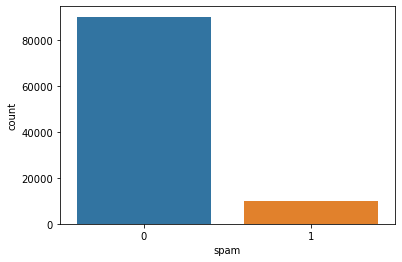

In [26]:
spamCount = df[df['spam']==1].shape[0]
goodCount = df[df['spam']==0].shape[0]

sns.countplot(data=df, x='spam')

print('Spam Count:', spamCount)
print('Good Count:', goodCount)
print('Spam to Good Ratio:', spamCount/(spamCount+goodCount))

# Collecting Tweet data given research data

In [27]:
# tweetIDS = []
# temp = ''
# for count, val in enumerate(df['id']):
#     temp = temp + val + ','
#     if count != 0 and count % 99 == 0:
#         temp = temp[:-1]
#         tweetIDS.append(temp)
#         temp = ''

# tweetJSON = []

# for i in tweetIDS:
#     url = create_url(i)
#     json_response = connect_to_endpoint(url)
#     tweetJSON.append(json_response)

# tweetDF = pd.DataFrame(columns=['id', 'lang', 'created_at', 'source', 'text', 'like_count', 'reply_count', 'quote_count'])

# for val in tweetJSON:
#     for i in val['data']:
#         temp = {
#             'id': i['id'],
#             'lang': i['lang'],
#             'created_at': i['created_at'],
#             'source': i['source'],
#             'text': i['text'],
#             'like_count': i['public_metrics']['like_count'],
#             'reply_count': i['public_metrics']['reply_count'],
#             'quote_count': i['public_metrics']['quote_count']
#         }
        
#         tweetDF = tweetDF.append(temp, ignore_index=True)

# tweetDF.to_csv('tweets.csv')

<!-- tweetIDS = []
temp = ''
for count, val in enumerate(df['id']):
    temp = temp + val + ','
    if count != 0 and count % 99 == 0:
        temp = temp[:-1]
        tweetIDS.append(temp)
        temp = ''

tweetJSON = []

for i in tweetIDS:
    url = create_url(i)
    json_response = connect_to_endpoint(url)
    tweetJSON.append(json_response)

tweetDF = pd.DataFrame(columns=['id', 'lang', 'created_at', 'source', 'text', 'like_count', 'reply_count', 'quote_count'])

for val in tweetJSON:
    for i in val['data']:
        temp = {
            'id': i['id'],
            'lang': i['lang'],
            'created_at': i['created_at'],
            'source': i['source'],
            'text': i['text'],
            'like_count': i['public_metrics']['like_count'],
            'reply_count': i['public_metrics']['reply_count'],
            'quote_count': i['public_metrics']['quote_count']
        }
        
        tweetDF = tweetDF.append(temp, ignore_index=True)

tweetDF.to_csv('tweets.csv') -->

# Combing Tweet Data and Research Data

In [28]:
tweetDF = pd.read_csv('tweets.csv', index_col=[0])
tweetDF['id'] = tweetDF['id'].astype(str)
tweetDF['source'] = tweetDF['source'].astype(str)
tweetDF['text'] = tweetDF['text'].astype(str)


df['id'] = df['id'].astype(str)
df['spam'] = df['spam'].astype(int)

data = pd.merge(tweetDF,df, how='inner', on='id')
data.head()

,id,lang,created_at,source,text,like_count,reply_count,quote_count,spam
0,732113301182746624,en,2016-05-16T07:39:47.000Z,Tweetbot for iΟS,RT @odinodin: I just made a tool for inspectin...,0,0,0,0
1,732113301145014272,en,2016-05-16T07:39:47.000Z,Twitter for Android,HAPPY BIRTHDAY JOSEPH 💓 @JosephMorgan,0,0,0,0
2,732113301149089794,en,2016-05-16T07:39:47.000Z,Twitter for iPad,RT @zeecinema: Yeh inka dopahar ka program hai...,0,0,0,0
3,732113305376940032,en,2016-05-16T07:39:48.000Z,Twitter for Android,RT @iitian_kshitij: Actually they have become ...,0,0,0,0
4,732113305347612672,en,2016-05-16T07:39:48.000Z,Twitter for iPhone,@JaimesonPaul lock all windows and doors don't...,0,1,0,0


# Preprocessing

In [29]:
import spacy
nlp = spacy.load('en_core_web_sm')
stopwords = nlp.Defaults.stop_words

In [30]:
def clean_text(x):
    doc = nlp(x.lower())
    lemmas = [token.lemma_ for token in doc 
          if token.lemma_.isalnum() and token.lemma_ not in stopwords]
    x = ' '.join(lemmas)
    return x

In [31]:
data['text'] = data['text'].apply(clean_text)
data.head()

,id,lang,created_at,source,text,like_count,reply_count,quote_count,spam
0,732113301182746624,en,2016-05-16T07:39:47.000Z,Tweetbot for iΟS,rt I tool inspect datum reagent app tree struc...,0,0,0,0
1,732113301145014272,en,2016-05-16T07:39:47.000Z,Twitter for Android,happy birthday joseph,0,0,0,0
2,732113301149089794,en,2016-05-16T07:39:47.000Z,Twitter for iPad,rt yeh inka dopahar ka program hai watch phir ...,0,0,0,0
3,732113305376940032,en,2016-05-16T07:39:48.000Z,Twitter for Android,rt actually middle man,0,0,0,0
4,732113305347612672,en,2016-05-16T07:39:48.000Z,Twitter for iPhone,lock window door investigate odd noise sure ce...,0,1,0,0


# Visualization

Spam Count: 3345
Good Count: 43390
Spam to Good Ratio: 0.07157376698405905


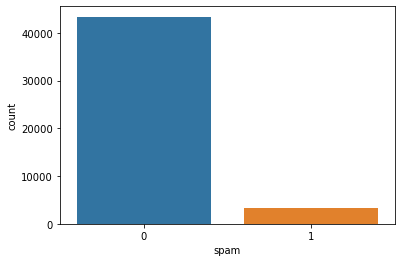

In [32]:
spamCount = data[data['spam']==1].shape[0]
goodCount = data[data['spam']==0].shape[0]

sns.countplot(data=data, x='spam')

print('Spam Count:', spamCount)
print('Good Count:', goodCount)
print('Spam to Good Ratio:', spamCount/(spamCount+goodCount))

In [33]:
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [34]:
np.random.seed(0)

# Predicting SPAM through Tweet Text

### Train Test Split

In [35]:
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['spam'], test_size=1/3)

vectorizer = TfidfVectorizer()
tfidf_X_train = vectorizer.fit_transform(X_train)
tfidf_X_test  = vectorizer.transform(X_test)

vectorizer_ng1 = CountVectorizer(ngram_range=(1,1))
ng1_X_train = vectorizer_ng1.fit_transform(X_train)
ng1_X_test  = vectorizer_ng1.transform(X_test)

vectorizer_ng2 = CountVectorizer(ngram_range=(1,2))
ng2_X_train = vectorizer_ng2.fit_transform(X_train)
ng2_X_test  = vectorizer_ng2.transform(X_test)

In [36]:
names = ['Logistic Regression', 
         'Random Forest', 
         'Naive Bayes']

models = [LogisticRegression(), 
          RandomForestClassifier(), 
          MultinomialNB()]

for cnt, model in enumerate(models):
    
    print('Predicting using {}'.format(names[cnt]))
    print('**************************************************')
    
    model.fit(tfidf_X_train, y_train)

    y_pred = model.predict(tfidf_X_test)
    
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print(accuracy_score(y_test, y_pred))
    
    model.fit(ng1_X_train, y_train)

    y_pred = model.predict(ng1_X_test)
    
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print(accuracy_score(y_test, y_pred))
    
    model.fit(ng2_X_train, y_train)

    y_pred = model.predict(ng2_X_test)
    
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print(accuracy_score(y_test, y_pred))
    
    print('--------------------------------------------------\n')
    

Predicting using Logistic Regression
**************************************************
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     14507
           1       0.96      0.54      0.69      1072

    accuracy                           0.97     15579
   macro avg       0.96      0.77      0.84     15579
weighted avg       0.97      0.97      0.96     15579

[[14482    25]
 [  491   581]]
0.9668784902753707
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     14507
           1       0.93      0.63      0.75      1072

    accuracy                           0.97     15579
   macro avg       0.95      0.81      0.87     15579
weighted avg       0.97      0.97      0.97     15579

[[14457    50]
 [  400   672]]
0.9711149624494512
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     14507
           1       0.96      0.66      0.78      

# Predicting SPAM through Tweet Source

### Train Test Split

In [37]:
X_train, X_test, y_train, y_test = train_test_split(data['source'], data['spam'], test_size=1/3)

vectorizer = TfidfVectorizer()
tfidf_X_train = vectorizer.fit_transform(X_train)
tfidf_X_test  = vectorizer.transform(X_test)

vectorizer_ng1 = CountVectorizer(ngram_range=(1,1))
count_X_train = vectorizer_ng1.fit_transform(X_train)
count_X_test  = vectorizer_ng1.transform(X_test)

vectorizer_ng2 = CountVectorizer(ngram_range=(1,2))
count_X_train = vectorizer_ng2.fit_transform(X_train)
count_X_test  = vectorizer_ng2.transform(X_test)

In [ ]:
names = ['Logistic Regression', 
         'Random Forest', 
         'Naive Bayes']

models = [LogisticRegression(), 
          RandomForestClassifier(), 
          MultinomialNB()]

for cnt, model in enumerate(models):
    
    print('Predicting using {}'.format(names[cnt]))
    print('**************************************************')
    
    model.fit(tfidf_X_train, y_train)

    y_pred = model.predict(tfidf_X_test)
    
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print(accuracy_score(y_test, y_pred))
    
    model.fit(ng1_X_train, y_train)

    y_pred = model.predict(ng1_X_test)
    
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print(accuracy_score(y_test, y_pred))
    
    model.fit(ng2_X_train, y_train)

    y_pred = model.predict(ng2_X_test)
    
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print(accuracy_score(y_test, y_pred))
    
    print('--------------------------------------------------\n')

Predicting using Logistic Regression
**************************************************
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     14430
           1       0.97      0.41      0.58      1149

    accuracy                           0.96     15579
   macro avg       0.96      0.71      0.78     15579
weighted avg       0.96      0.96      0.95     15579

[[14417    13]
 [  673   476]]
0.9559663649784967


C:\Program Files\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.93      1.00      0.96     14430
           1       0.08      0.00      0.01      1149

    accuracy                           0.92     15579
   macro avg       0.50      0.50      0.48     15579
weighted avg       0.86      0.92      0.89     15579

[[14386    44]
 [ 1145     4]]
0.9236793118942166


C:\Program Files\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.93      0.99      0.96     14430
           1       0.07      0.01      0.02      1149

    accuracy                           0.92     15579
   macro avg       0.50      0.50      0.49     15579
weighted avg       0.86      0.92      0.89     15579

[[14305   125]
 [ 1139    10]]
0.9188651389691251
--------------------------------------------------

Predicting using Random Forest
**************************************************
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     14430
           1       0.95      0.44      0.60      1149

    accuracy                           0.96     15579
   macro avg       0.95      0.72      0.79     15579
weighted avg       0.96      0.96      0.95     15579

[[14401    29]
 [  640   509]]
0.9570575775081841
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     14430
   